# Drift analysis of PMID26623667

Tong Shu Li

We look at the drift for the filtered transcriptome only.

### Questions

1. Do we see an increase in drift over time in the control worms?
2. Does mianserin significantly reduce drift?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys

In [2]:
sys.path.append("../..")

In [3]:
from src.plots import plot_multi_density

In [4]:
%matplotlib inline
%load_ext rpy2.ipython

In [5]:
%%R
sessionInfo()

R version 3.3.0 (2016-05-03)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: Fedora 23 (Workstation Edition)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     


---

## Read filtered transcriptome

In [6]:
data = (pd
    .read_csv("../../data/PMID26623667/clean_annotated_cpm_values.tsv", sep = '\t')
    .replace("water", "control")
)

In [7]:
data.shape

(391644, 13)

In [8]:
data.head()

,seqname,samples,cpm_value,cohort,replicate,day_harvested,drug,drug_conc_uM,day_drug_added,youngref_cpm,RLFEC,wormbaseid,gene_symbol
0,2RSSE.1,11,4.55942,1,1,1,control,0,1,4.105726,0.104814,WBGene00007064,2RSSE.1
1,2RSSE.1,12,3.21332,1,2,1,control,0,1,4.105726,-0.245078,WBGene00007064,2RSSE.1
2,2RSSE.1,13,4.54444,1,3,1,control,0,1,4.105726,0.101521,WBGene00007064,2RSSE.1
3,2RSSE.1,21,11.43680,2,1,3,control,0,1,4.105726,1.024454,WBGene00007064,2RSSE.1
4,2RSSE.1,22,4.77467,2,2,3,control,0,1,4.105726,0.150942,WBGene00007064,2RSSE.1


In [9]:
data["seqname"].nunique()

10879

In [10]:
data["log_cpm"] = np.log(data["cpm_value"])
data["ref_log_cpm"] = np.log(data["youngref_cpm"])

---

## Plot CPM distribution

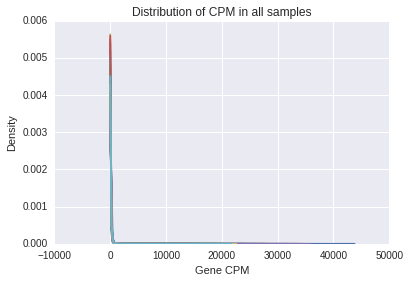

In [11]:
ax = plot_multi_density(
    data, ["cohort", "replicate"], "cpm_value"
)

ax.legend().set_visible(False)
ax.set_title("Distribution of CPM in all samples")
ax.set_xlabel("Gene CPM");

The raw CPMs need to be log normalized.

### Distribution of log CPM for all relevant samples

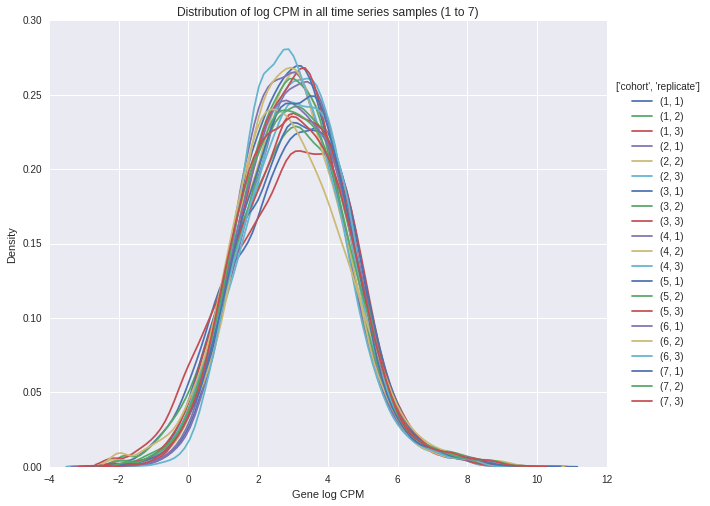

In [12]:
ax = plot_multi_density(
    data.query("cohort <= 7"), ["cohort", "replicate"], "log_cpm",
    rc = {"figure.figsize": (10, 8)}
)

ax.set_title("Distribution of log CPM in all time series samples (1 to 7)")
ax.set_xlabel("Gene log CPM");

I think these log CPM distributions aren't perfect but are good enough that I don't need to remove any of them.

## Distribution of RLFEC

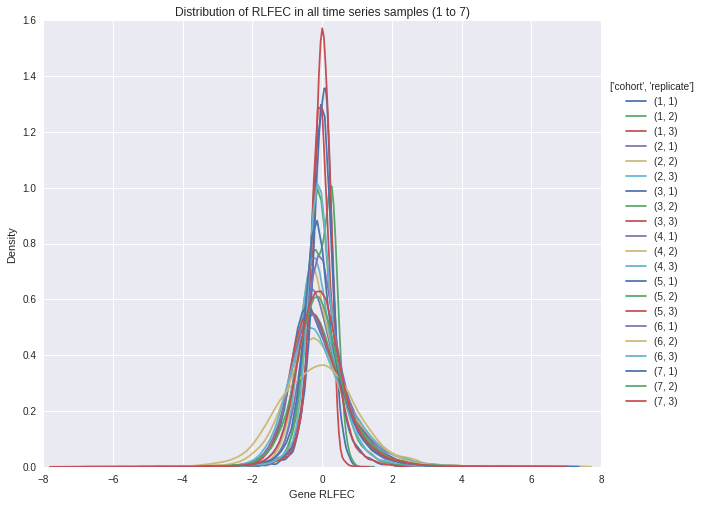

In [13]:
ax = plot_multi_density(
    data.query("cohort <= 7"), ["cohort", "replicate"], "RLFEC",
    rc = {"figure.figsize": (10, 8)}
)

ax.set_title("Distribution of RLFEC in all time series samples (1 to 7)")
ax.set_xlabel("Gene RLFEC");

Looks like sample 6, replicate 2 is very different from all the other samples. We will probably need to remove it.

---

## Calculate drift

In [14]:
drift = (
    data.groupby(
        [
            "cohort", "replicate", "samples", "day_harvested",
            "drug", "drug_conc_uM", "day_drug_added"
        ],
        as_index = False
    )
        .agg({"RLFEC": np.var})
        .rename(columns = {"RLFEC": "drift"})
        .sort_values(["cohort", "replicate"])
        .assign(log_day = lambda df: np.log(df["day_harvested"]))
)

In [15]:
drift

,cohort,replicate,samples,day_harvested,drug,drug_conc_uM,day_drug_added,drift,log_day
0,1,1,11,1,control,0,1,0.105572,0.000000
1,1,2,12,1,control,0,1,0.176070,0.000000
2,1,3,13,1,control,0,1,0.123187,0.000000
3,2,1,21,3,control,0,1,0.659756,1.098612
4,2,2,22,3,control,0,1,0.562372,1.098612
5,2,3,23,3,control,0,1,0.522795,1.098612
6,3,1,31,5,control,0,1,0.776546,1.609438
7,3,2,32,5,control,0,1,0.779723,1.609438
8,3,3,33,5,control,0,1,0.743515,1.609438
9,4,1,41,10,control,0,1,0.857668,2.302585


# Model building

Can we model drift as a function of time and other variables? We will examine how well a linear regression can model drift.

Our dependent variable is drift, and the independent variables are time (continuous) and drug treatment (categorical).

## Plot drift (linear model, no outliers removed)

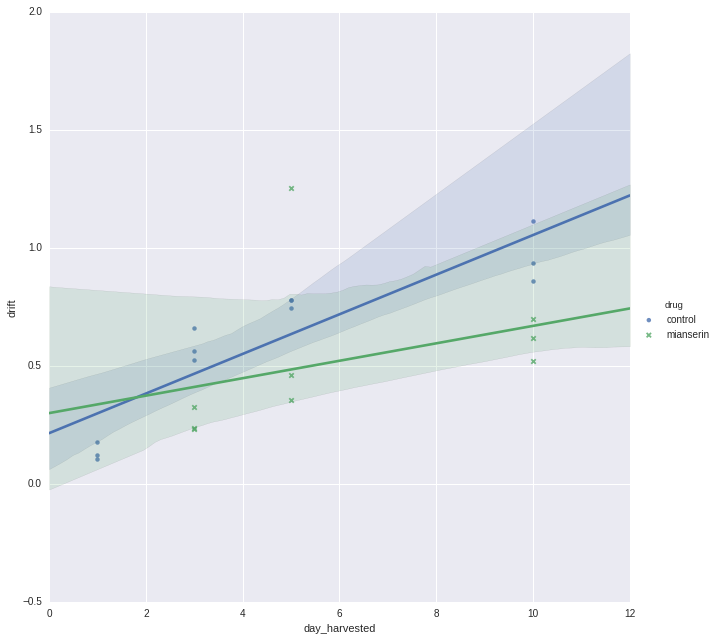

In [16]:
sns.lmplot(
    data = drift.query("cohort <= 7"),
    x = "day_harvested", y = "drift",
    hue = "drug", size = 9, markers = ['o', 'x']
);

Now that we are plotting individual samples as single numbers, it is much easier to see that sample 6, replicate 2 (day 5 harvest) is very different from the rest of the mianserin samples on day 5. If we examine the RLFEC and expression distributions, we will note that they look very different from the other samples, and confirms our suspicion that it is an outlier.

We will remove it and replot.

## Remove the outlier sample (sample 6, replicate 2)

Create a dataframe with the good results that we can pass to R.

In [17]:
good = drift.query("cohort <= 7 & samples != 62")

In [18]:
good

,cohort,replicate,samples,day_harvested,drug,drug_conc_uM,day_drug_added,drift,log_day
0,1,1,11,1,control,0,1,0.105572,0.000000
1,1,2,12,1,control,0,1,0.176070,0.000000
2,1,3,13,1,control,0,1,0.123187,0.000000
3,2,1,21,3,control,0,1,0.659756,1.098612
4,2,2,22,3,control,0,1,0.562372,1.098612
5,2,3,23,3,control,0,1,0.522795,1.098612
6,3,1,31,5,control,0,1,0.776546,1.609438
7,3,2,32,5,control,0,1,0.779723,1.609438
8,3,3,33,5,control,0,1,0.743515,1.609438
9,4,1,41,10,control,0,1,0.857668,2.302585


## Drift without sample 6, replicate 2 (mianserin day 5) (linear model)

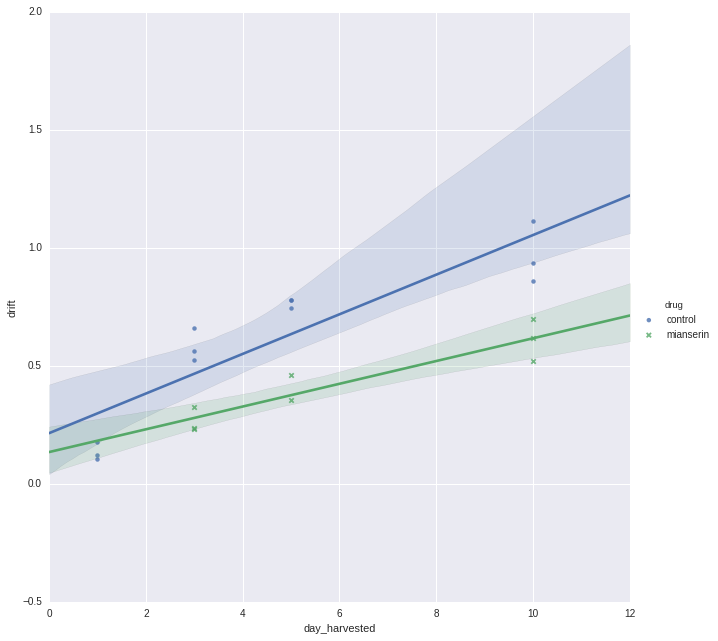

In [19]:
sns.lmplot(
    data = good,
    x = "day_harvested", y = "drift",
    hue = "drug", size = 9, markers = ['o', 'x']
);

The plot is much better with the outlier removed. However, the linear model doesn't seem to quite fit for the water treated animals.

### Fit a linear model

In [20]:
%%R -i good

summary(lm(drift ~ day_harvested + drug, data = good))


Call:
lm(formula = drift ~ day_harvested + drug, data = good)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.24155 -0.09857  0.02487  0.11362  0.17078 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.276196   0.061209   4.512 0.000308 ***
day_harvested  0.070927   0.009659   7.343 1.15e-06 ***
drugmianserin -0.280983   0.065422  -4.295 0.000490 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1403 on 17 degrees of freedom
Multiple R-squared:  0.7851,	Adjusted R-squared:  0.7599 
F-statistic: 31.06 on 2 and 17 DF,  p-value: 2.105e-06



In [21]:
%%R -i good

summary(lm(drift ~ day_harvested * drug, data = good))


Call:
lm(formula = drift ~ day_harvested * drug, data = good)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.19610 -0.10310  0.02190  0.08959  0.19354 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  0.21440    0.06543   3.277  0.00475 ** 
day_harvested                0.08394    0.01126   7.453 1.37e-06 ***
drugmianserin               -0.08003    0.12132  -0.660  0.51885    
day_harvested:drugmianserin -0.03573    0.01866  -1.914  0.07364 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1305 on 16 degrees of freedom
Multiple R-squared:  0.8252,	Adjusted R-squared:  0.7924 
F-statistic: 25.17 on 3 and 16 DF,  p-value: 2.676e-06



In [22]:
%%R -i good

model1 <- lm(drift ~ day_harvested + drug, data = good)
model2 <- lm(drift ~ day_harvested * drug, data = good)

anova(model1, model2)

Analysis of Variance Table

Model 1: drift ~ day_harvested + drug
Model 2: drift ~ day_harvested * drug
  Res.Df     RSS Df Sum of Sq      F  Pr(>F)  
1     17 0.33486                              
2     16 0.27246  1  0.062401 3.6645 0.07364 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


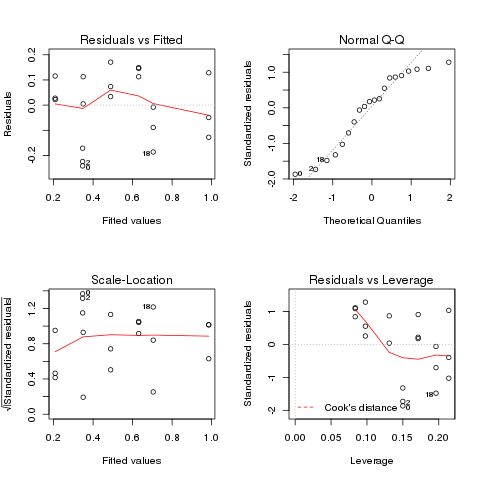

In [23]:
%%R -i good

par(mfrow = c(2, 2))
plot(lm(drift ~ day_harvested + drug, data = good))

When we fit a linear model of drift as a function of the day harvested and drug treatment, we see that both variables are significant, but that the interaction between them is not (`anova()` results).

The adjusted R-squared value for the linear model is 0.7599, which is pretty good.

### Residuals

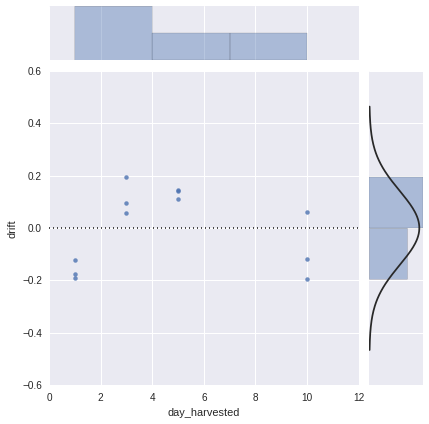

In [24]:
sns.jointplot(
    data = drift.query("cohort <= 7 & samples != 62 & drug == 'control'"),
    x = "day_harvested", y = "drift",
    kind = "resid"
);

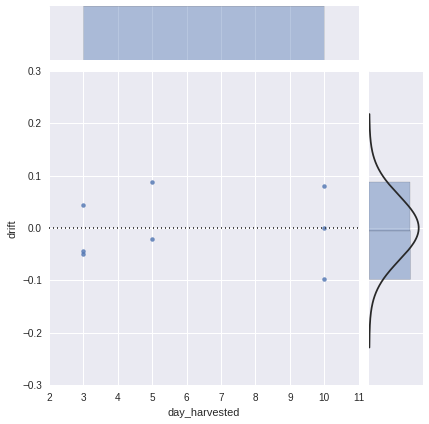

In [25]:
sns.jointplot(
    data = drift.query("cohort <= 7 & samples != 62 & drug == 'mianserin'"),
    x = "day_harvested", y = "drift",
    kind = "resid"
);

After removing sample 6 replicate 2, we see that the mianserin data follows a very nice linear relationship in terms of drift growth over time. The water data doesn't seem to follow a linear relationship. I would guess that it's rather log normal or of a higher order polynomial.

## Log linear model

Here we say that `drift ~ log(day_harvested)`

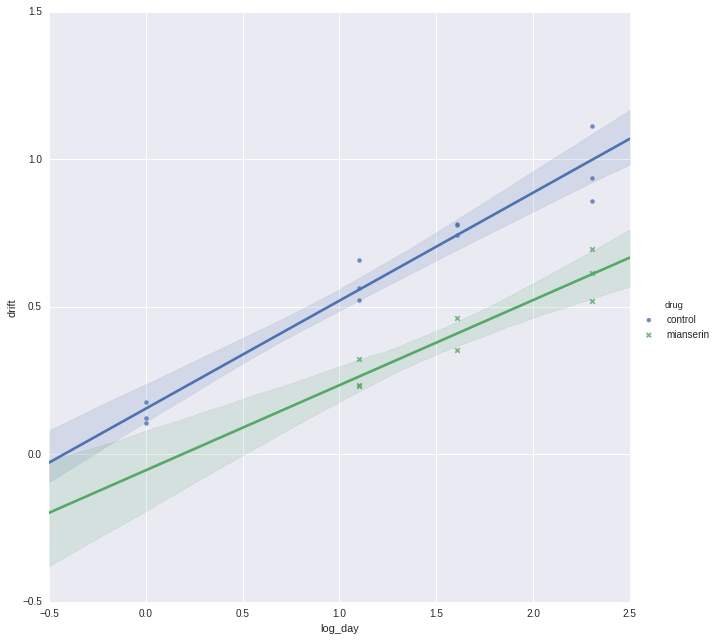

In [26]:
sns.lmplot(
    data = good,
    x = "log_day", y = "drift",
    hue = "drug", size = 9, markers = ['o', 'x']
);

In [27]:
%%R -i good

summary(lm(drift ~ log(day_harvested) + drug, data = good))


Call:
lm(formula = drift ~ log(day_harvested) + drug, data = good)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.130058 -0.045988  0.003154  0.043388  0.133398 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         0.17480    0.03544   4.932 0.000126 ***
log(day_harvested)  0.34990    0.02261  15.476 1.88e-11 ***
drugmianserin      -0.33222    0.03503  -9.484 3.35e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0738 on 17 degrees of freedom
Multiple R-squared:  0.9406,	Adjusted R-squared:  0.9336 
F-statistic: 134.6 on 2 and 17 DF,  p-value: 3.782e-11



In [28]:
%%R -i good

summary(lm(drift ~ log(day_harvested) * drug, data = good))


Call:
lm(formula = drift ~ log(day_harvested) * drug, data = good)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.139498 -0.037793  0.002762  0.040304  0.116697 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       0.15488    0.03714   4.170 0.000722 ***
log(day_harvested)                0.36580    0.02462  14.855 8.84e-11 ***
drugmianserin                    -0.20895    0.09290  -2.249 0.038937 *  
log(day_harvested):drugmianserin -0.07750    0.05435  -1.426 0.173128    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07165 on 16 degrees of freedom
Multiple R-squared:  0.9473,	Adjusted R-squared:  0.9374 
F-statistic: 95.85 on 3 and 16 DF,  p-value: 1.942e-10



In [29]:
%%R -i good

model1 <- lm(drift ~ log(day_harvested) + drug, data = good)
model2 <- lm(drift ~ log(day_harvested) * drug, data = good)

anova(model1, model2)

Analysis of Variance Table

Model 1: drift ~ log(day_harvested) + drug
Model 2: drift ~ log(day_harvested) * drug
  Res.Df      RSS Df Sum of Sq      F Pr(>F)
1     17 0.092589                           
2     16 0.082150  1  0.010439 2.0331 0.1731


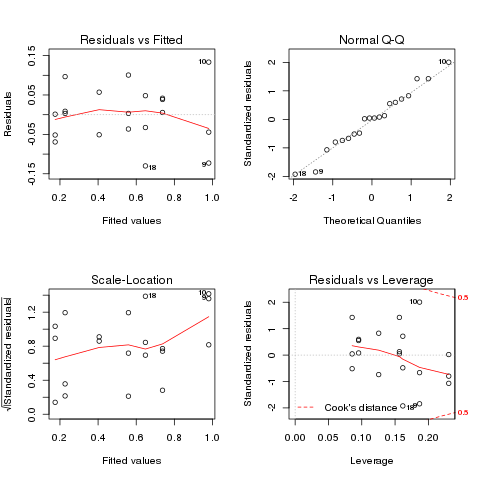

In [30]:
%%R -i good
par(mfrow = c(2, 2))
plot(lm(drift ~ log(day_harvested) + drug, data = good))

When we fit a log-linear model for drift, the R-squared value increased significantly to 0.9336. Again there does not seem to be a significant interaction term between the log day harvested and the drug treatment, which means that the slope of the regression lines for the two groups are parallel.

### Residuals

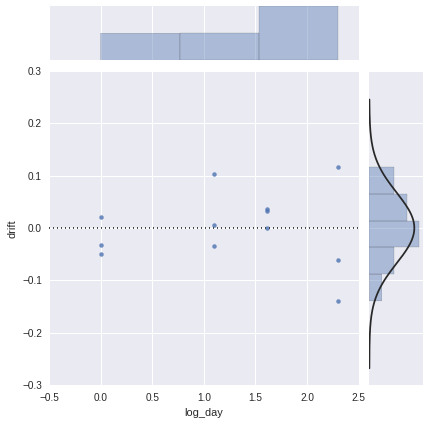

In [31]:
sns.jointplot(
    data = drift.query("cohort <= 7 & samples != 62 & drug == 'control'"),
    x = "log_day", y = "drift",
    kind = "resid"
);

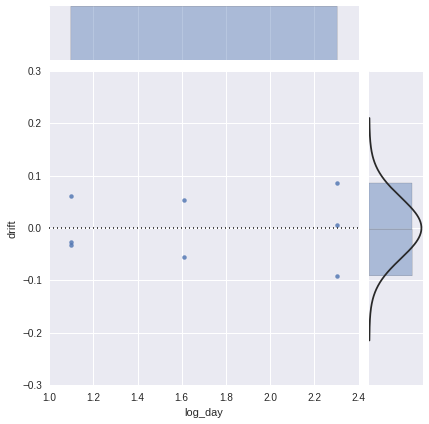

In [32]:
sns.jointplot(
    data = drift.query("cohort <= 7 & samples != 62 & drug == 'mianserin'"),
    x = "log_day", y = "drift",
    kind = "resid"
);

The residuals for mianserin with a log linear model look more like random variation (symmetric about zero). The model may still be a bit off for the water data though.

## Conclusion

The dataset does indeed tend to drift over time. Specifically it seems that drift increases with the log of time. Mianserin treated worms look like they drift at the rate as control worms, but have less overall drift at each measured time point.